In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt

import os
import sys
import logging

In [2]:
adata_infile = "/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/h5ad_objects/stream_input_filtered_cells.h5ad"
stream_outs_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs/no_rerun_pca'
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/data'
stream_obj = os.path.join(stream_outs_path,'stream_traj_no_pca.pkl')

In [3]:
!rsync -aP $adata_infile $stream_obj /dev/shm/

sending incremental file list


# Run stream dim reduction (LLE) on the anndata, with imputed gene expression and filtered cells

In [8]:
import stream as st
#read the stream result file pkl
adata_unprocessed = st.read(file_name='/dev/shm/' + os.path.basename(adata_infile), workdir=stream_outs_path)

Saving results in: /ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs/no_rerun_pca


In [11]:
from joblib import load
adata = load('/dev/shm/' + os.path.basename(stream_obj))

In [12]:
adata

AnnData object with n_obs × n_vars = 35699 × 3347
    obs: 'gem_well', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'BC1', 'BC2', 'BC3', 'BC4', 'BC5', 'BC6', 'BC7', 'BC8', 'BC9', 'BC10', 'BC11', 'BC12', 'BC13', 'BC14', 'BC15', 'BC16', 'BC17', 'BC18', 'BC19', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'Sample', 'leiden', 'leiden_res_0.10', 'leiden_res_0.25', 'leiden_res_0.50', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21', 'topic_22', 'topic_23', 'topic_24', 'topic_25', 'topic_26', 'topic_27', 'topic_28', 'topic_29', 'topic_30', 'topic_31', 'topic_32', 'topic_33', 'topic_34', 'topic_35', 'topic_36', 'irf4_prdm1_upDEG', 'irf4

In [13]:
#set the imputed gene expression as the accessible data layer
adata.X = adata.layers['MAGIC_imputed_data']

#### run on all highly_variable imputed genes (4k)

In [28]:
#st.select_variable_genes(adata,loess_frac=0.01,percentile=95)

In [ ]:
# 'var_genes' vs 'all' uses all the imputed, highly variable genes hence make sure the number of vars are only 3k/4k
st.dimension_reduction(adata,method='se',feature='all',n_components=2,n_neighbors=30,n_jobs=64) # using the same knn as diffusion maps (default is 30)

#### Order cell types based on how you think the pseudotime should be

In [14]:
import pandas as pd
adata.obs['leiden'] = pd.Categorical(
    adata.obs['leiden'],
    categories=['ActB-1', 'ActB-2', 'ActB-3', 'earlyPB', 'GC-2', 'GC-1', 'PB-1', 'PB-2'],
    ordered=True
)

In [15]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: DM_EigenVectors, X_diffmap, X_draw_graph_fa, X_joint_umap_features, X_pca, X_topic_compositions, X_umap, X_umap_features, X_se, X_dr, X_spring, X_stream_S2)


In [16]:
print(adata.uns['leiden_colors'])

['firebrick' 'limegreen' 'firebrick' 'lightcoral' 'lightskyblue'
 'mediumorchid' 'darkblue' 'green']


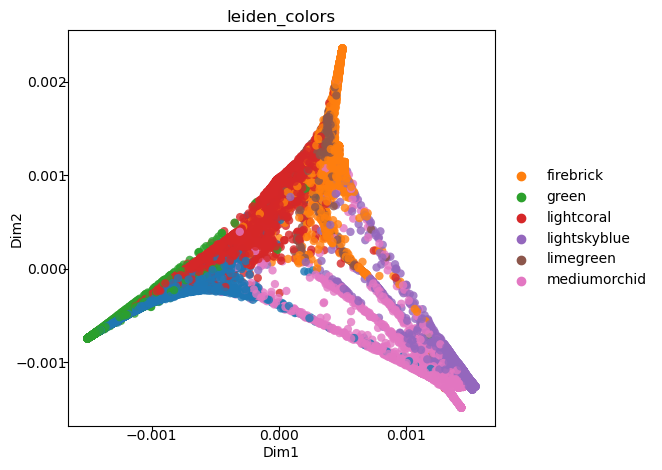

In [17]:
st.plot_dimension_reduction(adata,color=['leiden_colors'],n_components=2)


In [20]:
# Create a custom dictionary mapping sub_cell_types to colors
# color_dict = {
#     '1_ABC': '#FF7F00',    # Orange
#     '2_UD_4': '#006400',   # Dark green
#     '3_GC': '#D62728',     # Red
#     '4_Day 3 cells': '#9467BD',  # Purple
#     '6_MBC from GC': '#E377C2',  # Pink
#     '7_PB': '#808000',     # Olive Green
#     '8_UD_2': '#17BECF',   # Cyan
#     '9_UD_1': '#87CEEB',   # Sky Blue
#     '10_UD_0': '#FFE4B5',  # Very Light Orange
#     '11_UD_3': '#D3D3D3'   # Light Gray
# }
# Create the color dict from the uns storing the colors for the ordered sub_cell_types which are a pd.Categorical object with the ordered categories being the keys and the colors being the values
color_dict = dict(zip(adata.obs['leiden'].cat.categories, adata.uns['leiden_colors']))
# Add a new column to obs with the color for each cell
adata.obs['leiden_colors'] = adata.obs['leiden'].map(color_dict)

# Verify the new column
print(adata.obs[['leiden', 'leiden_colors']].head())

                     leiden leiden_colors
AAACAGCCAAACTAAG-1     GC-2  lightskyblue
AAACAGCCAATAATGG-7  earlyPB    lightcoral
AAACAGCCAATTGACT-6   ActB-1     firebrick
AAACAGCCACAACAAA-4   ActB-1     firebrick
AAACAGCCACAGACTC-5     GC-1  mediumorchid


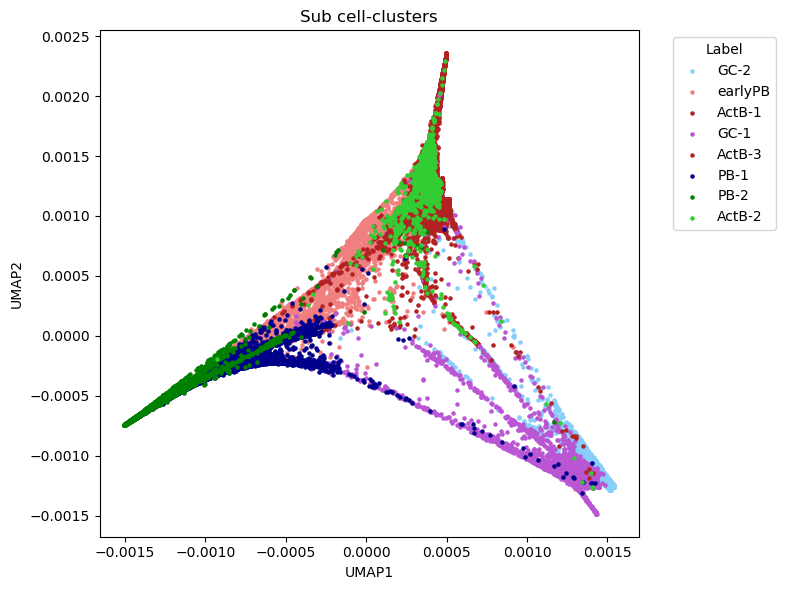

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring
labels = adata.obs['leiden']

# Get unique labels and their corresponding colors
unique_labels = labels.unique()
color_list = [color_dict[label] for label in unique_labels]

# Plotting the UMAP with colors based on labels
plt.figure(figsize=(8, 6))

for label, color in zip(unique_labels, color_list):
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=color, label=label, s=5)  # s=5 sets the marker size to 5 points

plt.title('Sub cell-clusters')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.legend(title="Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Visualize selected cells on the trajectory
### Plot days of cells on trajectory embeddings

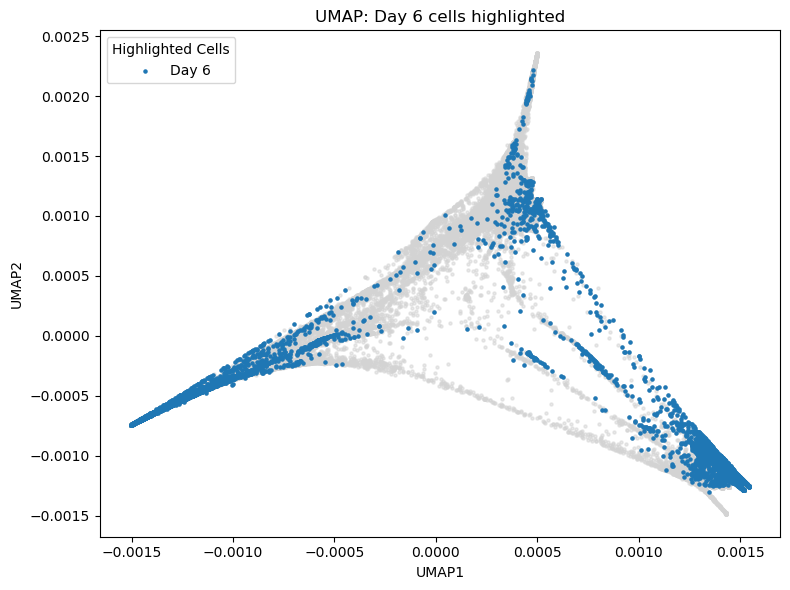

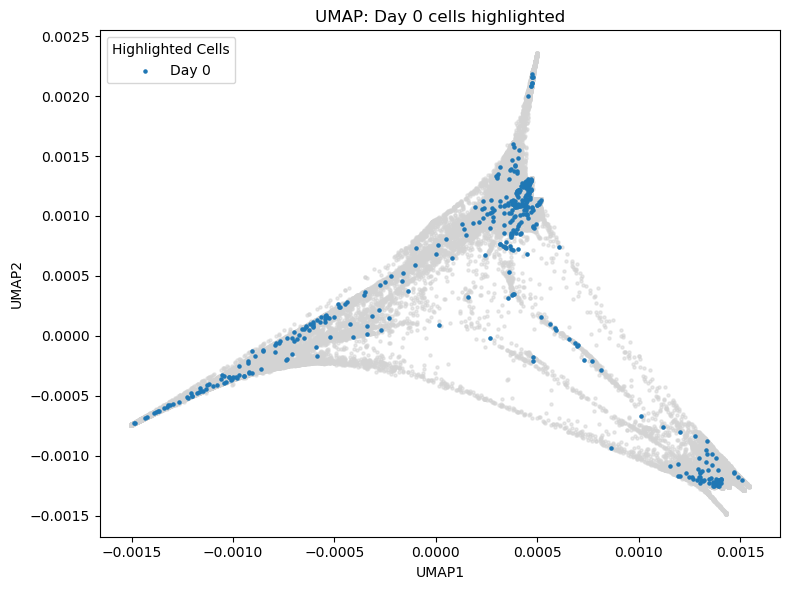

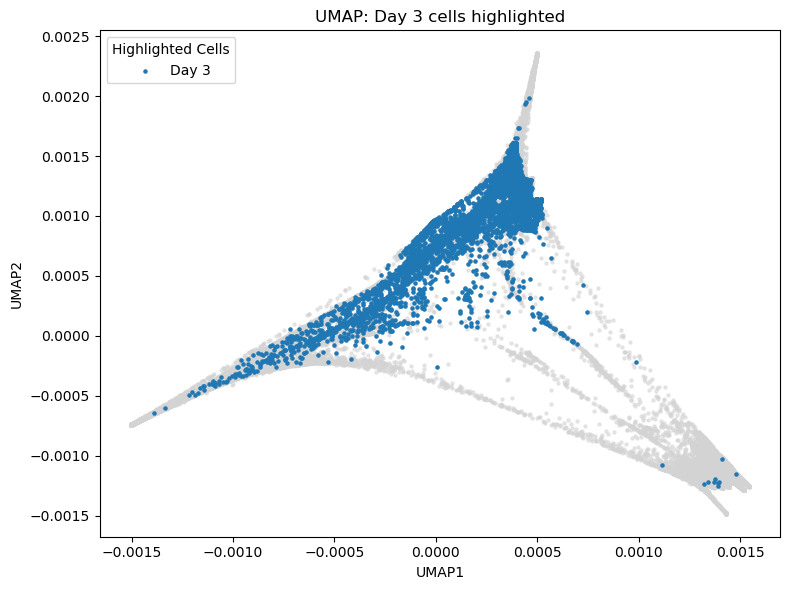

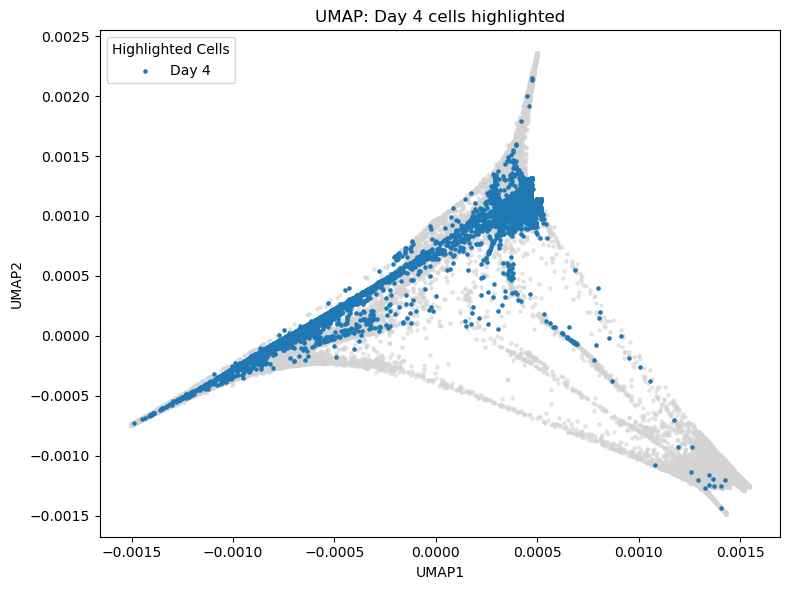

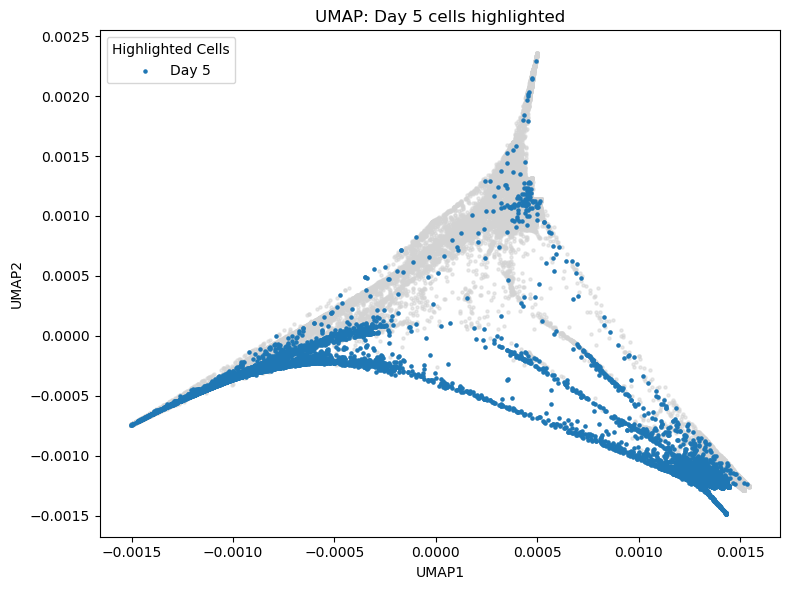

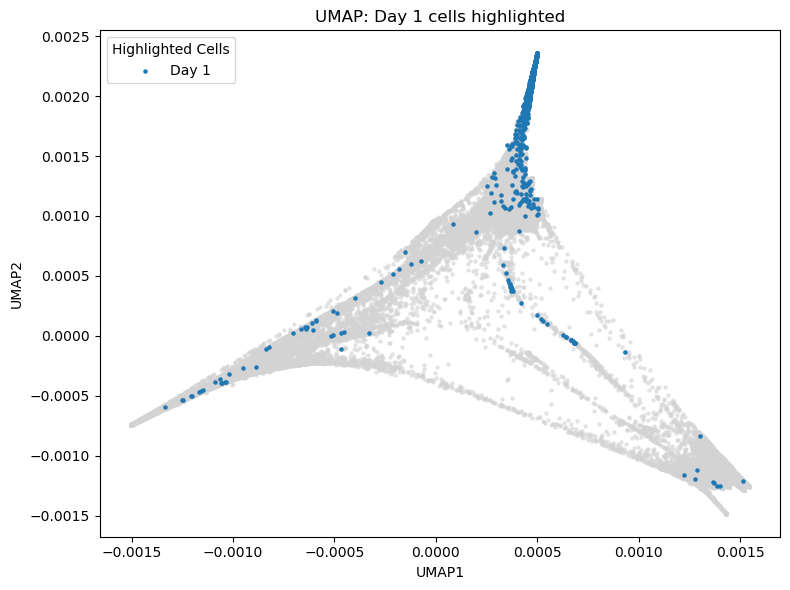

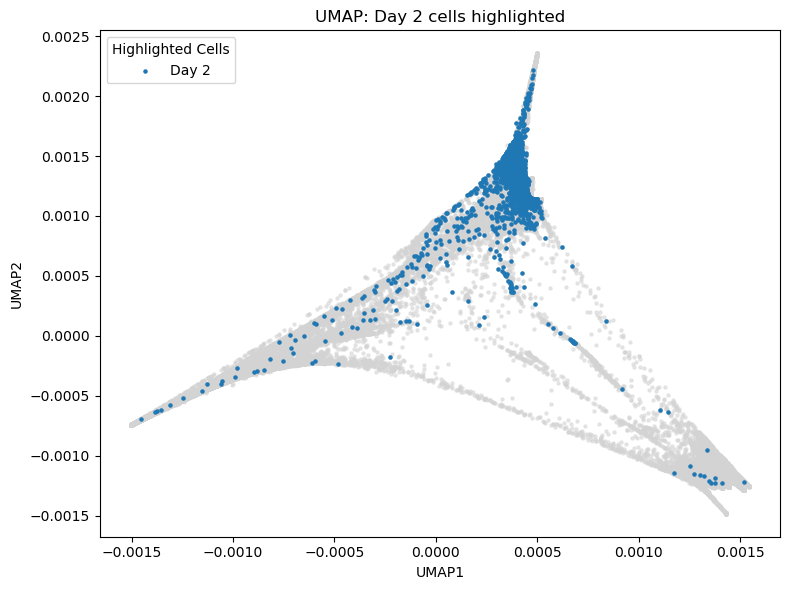

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Extract UMAP coordinates from the 'X_dr' slot 
umap_coords = adata.obsm['X_dr']

# Extract the labels for coloring (Day labels)
labels = adata.obs['Sample']

# Get unique labels
unique_labels = labels.unique()

# Define a color for the highlighted cells and for the background cells
highlight_color = '#1f77b4'  # A shade of blue
background_color = '#D3D3D3'  # Light gray

# Create a plot for each unique label
for label in unique_labels:
    plt.figure(figsize=(8, 6))
    
    # Plot background (gray) points first
    plt.scatter(umap_coords[:, 0], umap_coords[:, 1], c=background_color, s=5, alpha=0.5)
    
    # Plot highlighted points
    idx = labels == label
    plt.scatter(umap_coords[idx, 0], umap_coords[idx, 1], c=highlight_color, s=5, label=label)

    plt.title(f'UMAP: {label} cells highlighted')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title="Highlighted Cells", loc='upper left')
    plt.tight_layout()
    plt.show()

## Trajectory inference by fitting elastic graph

In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "64"
from tempfile import TemporaryDirectory
from rpy2.robjects import r
# Load the rlang package in R
r('library(rlang)')

# Parameters for STREAM (tune to your dataset)
ka1={'epg_alpha':0.02,'epg_mu':0.07,'epg_lambda':0.02,'epg_trimmingradius':2} # epg_mu needs to be tuned to get a good branch for day-1 to activated and undefined cells
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

# Trajectory inference
with TemporaryDirectory() as td:
	st.set_workdir(adata,td)
	st.seed_elastic_principal_graph(adata,n_clusters=10)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)
	

In [ ]:
st.optimize_branching(adata,incr_n_nodes=30) #smoothen out the branches

In [ ]:
st.plot_branches(adata,show_text=True)

In [ ]:
import matplotlib.pyplot as plt

st.plot_dimension_reduction(adata,show_graph=True,show_text=True,color=['leiden_colors'])
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


In [ ]:
###Extend leaf branch to reach further cells 
st.extend_elastic_principal_graph(adata, epg_ext_mode='WeigthedCentroid',epg_ext_par=0.8)
st.plot_dimension_reduction(adata,color=['leiden_colors'],n_components=2,show_graph=True,show_text=True)
st.plot_branches(adata,show_text=True)

In [ ]:
#Replace S3 with your own starting node if on a different dataset
st.plot_dimension_reduction(adata,color=['S2_pseudotime','branch_id_alias'])


In [ ]:
st.plot_flat_tree(adata,color=['leiden_colors','S2_pseudotime','branch_id_alias'],
                  dist_scale=0.5,show_graph=True,show_text=True)


### Verifying genes of interest's expression per branch on the trajectory

In [ ]:
st.plot_stream_sc(adata,root='S2',color=['BATF','IRF4', 'SPIB', 'BCL6', 'IRF8', 'PRDM1'], vmin=0, vmax=1.5,dist_scale=0.3,show_graph=True,show_text=True)

In [ ]:
adata.obs.head()

In [32]:
# save the S2_pseudotime with barcodes (taken from obs.index) to a csv
pseudotime_df = pd.DataFrame({'Barcode': adata.obs.index, 'S2_pseudotime': adata.obs['S2_pseudotime']})
pseudotime_df.to_csv('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs/S2_pseudotime.csv', index=False)


In [26]:
# write stream result to pkl
st.write(adata,file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs/stream_traj_no_pca.pkl')


In [27]:
import numpy as np
import pandas as pd
# Extract node names from pseudotime columns
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[adata.obs.index,x+'_pseudotime'].values for x in dimnodes]).T
node_dict=dict(zip(dimnodes,range(len(dimnodes))))
branch = np.array([
    sorted([node_dict.get(y.strip('() \''), None) for y in x])
    for x in adata.obs['branch_id_alias']
])

# save the branch, edge, and dist files
stream_outs_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/stream_outs'
# The branch each cell is on (cell:(node_start,node_end))
branch=pd.DataFrame(branch,index=adata.obs.index)
branch.to_csv(os.path.join(stream_outs_path,'branch.tsv.gz'),header=False,index=False,sep='\t')

# Identify and save unique edges between nodes
edge=np.unique(branch.values,axis=0)
edge=pd.DataFrame(edge)
edge.to_csv(os.path.join(stream_outs_path,'edge.tsv.gz'),header=False,index=False,sep='\t')

# The distance of each cell to each node (cell:node, value is pseudotime distance)
dist=pd.DataFrame(dist,index=adata.obs.index,columns=dimnodes)
dist.to_csv(os.path.join(stream_outs_path,'dist.tsv.gz'),header=True,index=True,sep='\t')

#### Make subsets of the sub cell types

In [30]:
dictys_data_path = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_2nd_donor/dictys_outs/data'
adata.obs.leiden.to_csv(f'{dictys_data_path}/clusters.csv',header=['Cluster'],index=True,index_label='Barcode')


#### Make coord_rna.tsv.gz file of the cells and their lower dim coords, for dictys input

In [ ]:
import anndata as ad
import pandas as pd

# Convert the obs.index (cell barcodes) to a DataFrame
obs_index_df = pd.DataFrame(adata.obs.index)
# Create a new AnnData object with only the cell barcodes and X_dr from obsm
adata_reduced = ad.AnnData(
    obs=obs_index_df,  # Use the cell barcodes as the obs DataFrame
    obsm={"X_dr": adata.obsm['X_dr']}  # Keep only 'X_dr' from obsm
)
# Confirm that the new AnnData object has the correct structure
adata_reduced

In [ ]:
import os
import pandas as pd

# Extract the relevant columns from the AnnData object
# The cell barcodes (obs.index) and 'X_dr' from obsm
cell_barcodes = adata.obs.index
xy_coords = adata_reduced.obsm['X_dr']

# Create a DataFrame with cell barcodes as the first column and 'X_dr' as the next columns
coord_df_b_cell = pd.DataFrame(data=xy_coords, columns=['x', 'y'])
coord_df_b_cell.insert(0, None, cell_barcodes)

#display the df
print(coord_df_b_cell.head())

In [31]:
# Save the DataFrame to a TSV file
output_path = os.path.join(dictys_data_path,'coord_rna.tsv.gz')
coord_df_b_cell.to_csv(output_path, sep='\t', compression='gzip', index=False, header=['', 'x', 'y'])

#### Inspecting tut adata (2 branches one)

In [ ]:
import stream as st
bcell_adata = st.read(file_name='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/day4_and_2_cells_added_traj/stream_result_all_cells.pkl', workdir='/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/stream_outs/day4_and_2_cells_added_traj')
bcell_adata


In [ ]:
# get max and min of pseudotime
print(bcell_adata.obs['S3_pseudotime'].max())
print(bcell_adata.obs['S3_pseudotime'].min())

In [ ]:
skin_adata = sc.read_h5ad('/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/tut_files/skin_data/tmp/adata_with_traj.h5ad')
skin_adata


In [ ]:
#plot dim reduction on basis X_dr and obs S3_pseudotime
sc.pl.embedding(skin_adata,basis='X_dr',color=['S3_pseudotime'],legend_loc='on data')

In [ ]:
# get max and min of S3_pseudotime
print(skin_adata.obs['S2_pseudotime'].max())
print(skin_adata.obs['S2_pseudotime'].min())